<h1>Практическая работа: "Бинарная логистическая регрессия"</h1>

__Задача бинарной классификации__

___Некая фирма провела анализ зависимости расхода денежных средств на рекламу и эффекта от нее. Если эффект присутствовал, 
то в датасете ставилась 1, в противном случае - 0. Результаты были представоены в виде двух DataFrame х и y.<br>
Произыести бинарную классификацию с использованием логистической регрессии.___  

In [109]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
#Исходные данные: x - расходы на рекламу, Y - объемы продаж
x = pd.DataFrame(np.array([39, 36, 60, 21, 27, 12, 51, 57, 54, 42, 18, 9, 48, 66, 6, 30, 24, 33, 15, 21, 100, 200]))
Y = pd.DataFrame(np.array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]))
#display(x, Y)

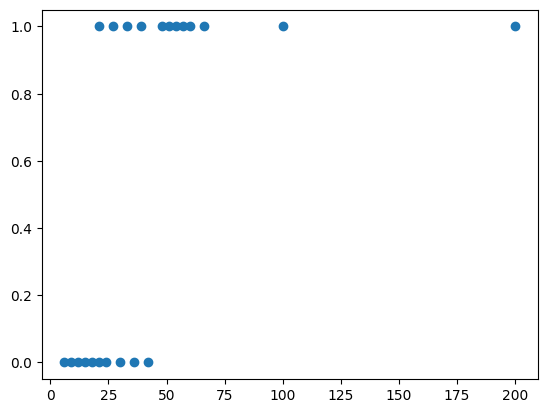

In [111]:
plt.scatter(x,Y)

_Попробуем разделить эти точки прямой линией, отделяющей один класс от другого. 
Модель начинает плохо работать в случае добавления новых точек на больших значениях x:_

In [112]:
a1 = ((x-x.mean())*(Y-Y.mean())).mean()/((x-x.mean())**2).mean()
a0 = Y.mean() - a1*x.mean()
print("Y = ", a0, " + ", a1, " * x")
x_space = np.linspace(6,70,20)
Y_pred = a0.item() + a1.item()*x_space

Y =  0    0.266493
dtype: float64  +  0    0.006333
dtype: float64  * x


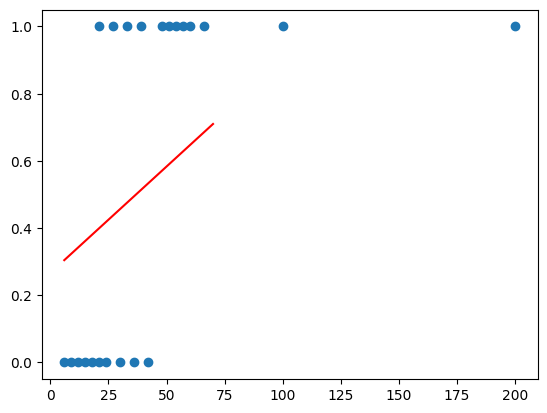

In [113]:
plt.plot(x_space, Y_pred, 'r')
plt.scatter(x, Y)

<h2>Функция логистической регрессии</h2>

__Сигмоида__

Возможное решение упомянутых выше сложностей — пропустить значение линейной регрессии через сигмоиду (sigmoid function), 
которая при любом значении x не выйдет из необходимого нам диапазона от 0 до 1. <br>
<h3>$g(x) = \frac{1}{1+ e^{-x}}$</h3>

 <img src='images/ris1.png' width=320, heigth=240>

<h3>Logistic loss или функция кросс-энтропии</h3>

В модели логистической регрессии мы не можем использовать MSE. Дело в том, 
что если мы поместим результат сигмоиды (представляющей собою нелинейную функцию) в MSE, 
то на выходе получим невыпуклую функцию (non-convex), глобальный минимум которой довольно сложно найти.
 <img src='images/ris2.png' width=520, heigth=240>
    Вместо MSE мы будем использовать функцию логистической ошибки, которую еще называют функцией бинарной кросс-энтропии (log loss, binary cross-entropy loss).

__График и формула функции логистической ошибки__<br>
 <img src='images/ris3.png' width=420, heigth=240>

$J(\theta)=-\frac{1}{n} \sum{y*log(h_{\theta}(x))+(1-y)*log(1-h_{\theta}(x))}$

<h3>Оценка качества модели</h3>

__Матрицa ошибок (confusion matrix)__<br>
 <img src='images/ris4.png' width=420, heigth=240><br>
Доля правильно предсказанных значений называется accuracy. Чтобы ее посчитать, мы берем те значения,
    которые предсказаны верно (TP + TN) и делим на общее количество прогнозов.<br>
    <h3>$accuracy=\frac{TP+TN}{TP+TN+FP+FN}$</h3>

<h2>Конкретизация задачи:</h2>

Реализовать класс модели логистической регрессии с использованием:

а) максимизации логарифмического правдоподобия методом градиентного подъема

б) минимизации функции потерь (кросс-энтропии) методом градиентного спуска

Сравнить результаты (время исполнения и достигнутые значения accuracy и f1) в случаях а и б при одном и том же числе шагов и скорости обучения.

In [114]:
#Реализуем цикл градиентного спуска
class LogisticRegressionGD(object):
    def __init__(self):
        self.a = np.zeros(2).reshape(1, 2)

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x @ self.a))

    def predict(self, x):
        return self.sigmoid(x)

    def coefs(self):
        return self.a

    def LogLikelihood(self, x, Y):
        return (Y * np.log(self.predict(x)) + (1 - Y) * np.log(1 - self.predict(x))).sum()

    def CrossEntropy(self, x, Y):
        return (-Y * np.log(self.predict(x)) - (1 - Y) * np.log(1 - self.predict(x))).sum()

    def accuracy(self, x, Y):
        return ((self.predict(x) > 0.5)==Y).mean()

    def fit(self, x, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "LL"):
        self.a = np.zeros (x.shape[1]).reshape(x.shape[1],1)
        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dT_a = x.T @(Y - self.predict(x)) / x.shape[0]
                self.a += alpha*dT_a
            elif Rtype == "CE":
                new_error = self.CrossEntropy(x, Y)
                #display(new_error)
                dT_a = -x.T @(Y - self.predict(x)) / x.shape[0]
                self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)
            #if new_error < epsylon:
            #    break
        return steps, errors

In [115]:
x_ = x.copy()

import time

intercept = np.ones((x.shape[0], 1))
x_ = pd.DataFrame(np.concatenate((intercept, x), axis = 1))

In [116]:
start_time_CE = time.time()
regr_CE = LogisticRegressionGD()
steps_CE, errors_CE =  regr_CE.fit(x_, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "CE")

display(f"Время обучения: {time.time() - start_time_CE} сек.")

start_time_LL = time.time()
regr_LL = LogisticRegressionGD()
steps_LL, errors_LL =  regr_LL.fit(x_, Y, alpha = 0.01, epsylon = 0.01, max_steps = 10000, Rtype = "LL")

display(f"Время обучения: {time.time() - start_time_LL} сек.")

'Время обучения: 20.373772621154785 сек.'

'Время обучения: 15.785595178604126 сек.'

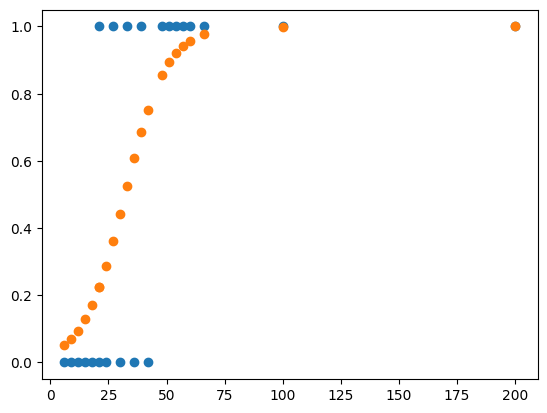

In [117]:
Y_Pred = regr_CE.predict(x_)
plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

In [118]:
display(regr_CE.coefs())
#display(x_)

,0
0,-3.598933
1,0.112155


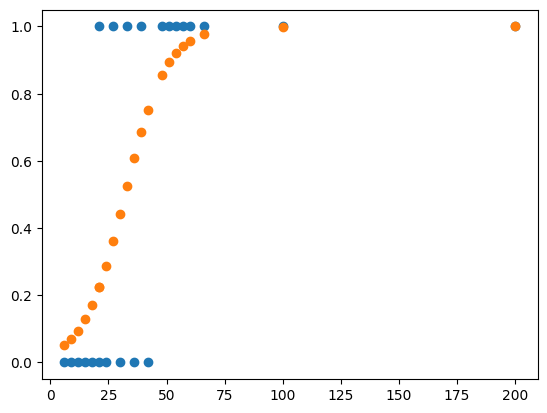

In [119]:
Y_Pred = regr_LL.predict(x_)
plt.scatter(x, Y)
plt.scatter(x, Y_Pred)

In [120]:
display(regr_LL.coefs())
#display(x_)

,0
0,-3.598933
1,0.112155


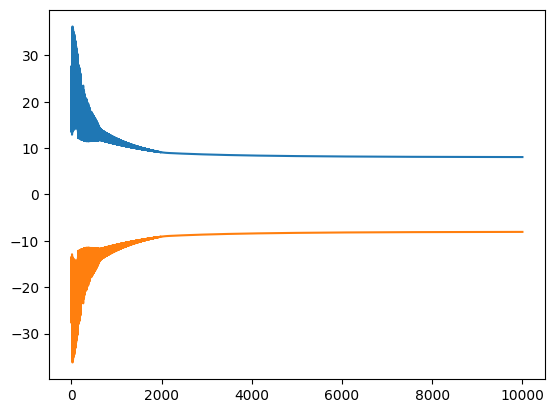

In [121]:
plt.plot(steps_CE, errors_CE)
plt.plot(steps_LL, errors_LL)

In [122]:
print(regr_CE.accuracy(x_, Y))
print(regr_LL.accuracy(x_, Y))

0    0.818182
dtype: float64
0    0.818182
dtype: float64


Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/
Для 151 406 договоров страхования транспортных средств известны значения ряда признаков, в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель, год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);
variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);
variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);
variable_4 - идентификатор года выпуска транспортного средства;
variable_5 - идентификатор страны - производителя транспортного средства;
variable_6 - мощность двигателя в лошадиных силах;
variable_7 - объем двигателя в куб. см;
variable_8 - идентификатор стороны расположения руля (левый или правый);
variable_9 - пробег транспортного средства, покрываемый гарантией производителя;
variable_10 - индикатор действия гарантии на транспортное средство;
variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;
variable_12 - возраст транспортного средства (в мес.);
variable_13 - возраст водителя с максимальным стажем;
variable_14 - коэффициент возраст-стаж;
variable_15 - коэффициент краткосрочности;
variable_16 - коэффициент мощности;
variable_17 - коэффициент "мультидрайв";
variable_18 - территориальный коэффициент;
variable_19 - коэффициент "КНДР";
variable_20 - идентификатор канала продаж;
variable_21 - марка транспортного средства;
variable_22 - модель транспортного средства;
variable_23 - индикатор отечественных транспортных средств;
variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";
variable_25 - индикатор пролонгации;
variable_26 - индикатор совпадения собственника транспортного средства и водителя;
variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";
variable_28 - тип транспортного средства;
target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.

variable_1        0
variable_4        0
variable_5        0
variable_6      111
variable_12    1528
variable_13    1657
variable_14    2927
variable_16      12
variable_17      12
variable_18      12
variable_19       0
variable_20       1
variable_21       0
variable_22       0
variable_24    2207
variable_26       0
variable_27    2067
target            0
dtype: int64
Уравнение гиперплоскости:
-0.1024*cat__variable_1_w12 + -0.1257*cat__variable_1_w145 + -0.0298*cat__variable_1_w156 + -0.2145*cat__variable_1_w160 + -0.0706*cat__variable_1_w190 + -0.0501*cat__variable_1_w199 + -0.0812*cat__variable_1_w2 + -0.1651*cat__variable_1_w200 + -0.0364*cat__variable_1_w29 + -0.0349*cat__variable_1_w333 + -0.0011*cat__variable_1_w45 + -0.0524*cat__variable_1_w48 + 0.0017*cat__variable_1_w49 + -0.0722*cat__variable_1_w90 + 0.0136*cat__variable_5_q1 + -0.0405*cat__variable_5_q10 + -0.0331*cat__variable_5_q11 + 0.0090*cat__variable_5_q12 + -0.0075*cat__variable_5_q13 + -0.0049*cat__variable_5_q14 +

/home/aleksey/Documents/mirea_lab/5 sem/algo-ml/venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


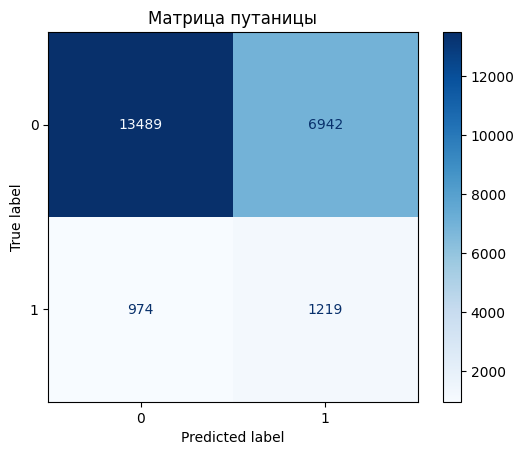


Метрики на тестовом наборе:
Accuracy: 0.6501
Precision: 0.1494
Recall: 0.5559
F1: 0.2355


In [ ]:
  import pandas as pd
  import numpy as np
  from sklearn.linear_model import LogisticRegression
  from sklearn.preprocessing import OneHotEncoder, StandardScaler
  from sklearn.compose import ColumnTransformer
  from sklearn.pipeline import Pipeline
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt

  # Загрузка данных
  train_df = pd.read_csv('insclass_train.csv', header=0, usecols=["variable_1", "variable_4", "variable_5", "variable_6", "variable_12", "variable_13", "variable_14", "variable_16", "variable_17", "variable_18", "variable_19", "variable_20", "variable_21", "variable_22", "variable_24", "variable_26", "variable_27", "target"])
  print(train_df.isna().sum())

  # Если test не найден, берём 22624 строк из train для test
  test_df = train_df.sample(n=22624, random_state=42)
  train_df = train_df.drop(test_df.index)

  train_df = train_df.fillna(0)
  test_df = test_df.fillna(0)

  # Преобразование всех категориальных колонок к str для избежания смешанных типов
  categorical_cols = train_df.select_dtypes(include=['object']).columns
  for col in categorical_cols:
      train_df[col] = train_df[col].astype(str)
      test_df[col] = test_df[col].astype(str)

  # X и y
  X_train = train_df.drop('target', axis=1)
  y_train = train_df['target']
  X_test = test_df.drop('target', axis=1)
  y_test = test_df['target']

  # Преобразователь: OneHotEncoder для категорий с handle_unknown='ignore'
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
      ],
      remainder='passthrough'  # Числовые колонки без изменений
  )

  # Пайплайн с нормализацией и моделью
  model = Pipeline([
      ('preprocessor', preprocessor),
      ('scaler', StandardScaler(with_mean=False)),  # Нормализация после OHE
      ('classifier', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'))
  ])

  # Обучение
  model.fit(X_train, y_train)

  # Уравнение (коэффициенты после OHE, так что уравнение будет сложным, выводим коэффициенты)
  coefficients = model.named_steps['classifier'].coef_[0]
  intercept = model.named_steps['classifier'].intercept_[0]
  features = model.named_steps['preprocessor'].get_feature_names_out()

  equation_terms = [f"{coef:.4f}*{feature}" for coef, feature in zip(coefficients, features)]
  equation = " + ".join(equation_terms) + f" + {intercept:.4f} = 0"

  print("Уравнение гиперплоскости:")
  print(equation)

  y_pred = model.predict(X_test)

  # Матрица путаницы
  cm = confusion_matrix(y_test, y_pred)
  print("Матрица путаницы на тестовом наборе:")
  print(cm)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Матрица путаницы")
  plt.show()

  # Метрики
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("\nМетрики на тестовом наборе:")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1: {f1:.4f}")